In [51]:
"""
Example script of WaveBlocks framework.
This script uses a Fourier Light Field (FLF) microscope with a Microlens Array (MLA)
Here, we define the microscope and forward project a volume of microspheres. 
We then use torch optimizers to reconstruct the volume.


# Erik Riedel & Josef Kamysek
# erik.riedel@tum.de & josef@kamysek.com
# 15/10/2020, Munich, Germany
"""


from numpy.linalg.linalg import det
import torch

# Third party libraries imports
import matplotlib.pyplot as plt
import numpy as np
import logging
import math
import os

# Waveblocks imports
import waveblocks
from waveblocks.microscopes.fourier_lightfield_mla_micro import Microscope, preset1
import waveblocks.evaluation.reconstruction_analysis as fwhm
import waveblocks.reconstruction.deconvolution.optimizer_reconstruction as recon
import waveblocks.evaluation.microspheres as ms
from waveblocks.blocks.optic_config import OpticConfig
from waveblocks.blocks.microlens_arrays import MLAType
import waveblocks.blocks.point_spread_function as psf
from waveblocks.utils import generate_phase_masks as pm
from waveblocks.utils.helper import get_free_gpu

# Set logging
logger = logging.getLogger("Waveblocks")
waveblocks.set_logging(debug_mla=False, debug_microscope=False, debug_richardson_lucy=False, debug_optimizer=True)

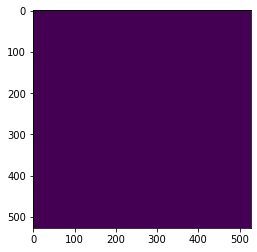

In [52]:
torch.set_num_threads(8)

work_dir = os.getcwd()

# Optical Parameters
depth_range = [-32, 32]
depth_step = 2
depths = np.arange(depth_range[0], depth_range[1] + depth_step, depth_step)
n_depths = len(depths)
# Change size of volume you are looking at
vol_xy_size = 151  # 17


# Fetch Device to use
device = torch.device("cuda:" + str(get_free_gpu()) if torch.cuda.is_available() else "cpu")

sphere_volume = ms.create_modulation_volume(vol_xy_size, vol_xy_size, n_depths, depth=15, final_modulation_width=5)

gt_volume = torch.from_numpy(sphere_volume).float().unsqueeze(0).unsqueeze(0).to(device)

gt_volume = gt_volume[:, 0, ...].permute(0, 3, 1, 2).contiguous()

# gt_volume = torch.zeros(gt_volume.shape,device=device)

gt_volume[0,15,:,:] = 1


# Create opticalConfig object with the information from the microscope
optic_config = preset1()

# Lateral size of PSF in pixels
psf_size = 17 * 31  # 17 * 11

# Define PSF
psf = psf.PSF(optic_config=optic_config, members_to_learn=[])
_, psf_in = psf.forward(optic_config.sensor_pitch / optic_config.PSF_config.M, psf_size, depths)

# Enable Fourier convolutions
optic_config.use_fft_conv = True

# --------------Define phase mask
optic_config.use_pm = True
# Number of pixels in phase mask
# compute pixel size at fourier plane of first lens
Fs = 1.0 / optic_config.sensor_pitch
cycles_perum = Fs / psf_in.shape[-2]
# incoherent resolution limit
resolution_limit = optic_config.PSF_config.wvl / (optic_config.PSF_config.NA * optic_config.PSF_config.M)
n_pix_in_fourier = resolution_limit / cycles_perum
# diameter of the objective back focal plane, which acts as the entrance pupil for our system
d_obj = optic_config.PSF_config.fobj * optic_config.PSF_config.NA
# sampling size on the fourier domain
fourier_metric_sampling = d_obj / n_pix_in_fourier

optic_config.pm_sampling = fourier_metric_sampling

# optic_config.pm_pixel_size = 8
optic_config.pm_pixel_size = 3.9

# optic_config.pm_shape = [
#     int(optic_config.pm_pixel_size / fourier_metric_sampling * 1080),
#     int(optic_config.pm_pixel_size / fourier_metric_sampling * 1920),
# ]
optic_config.pm_shape = [
    psf_size,
    psf_size,
]  # 512 [1054, 1054] # [187, 187] # [527,527]

optic_config.pm_max_phase_shift = 5.4 * math.pi

pm_image = pm.create_phasemask(
    pm.PhaseMaskType.cubic,
    pm.PhaseMaskShape.square,
    {
        "x": optic_config.pm_shape[0],
        "y": optic_config.pm_shape[1],
        "ratio": 0.4,  # 0.3,
        "offset": [0, 0],
    },
    information={"max_phase_shift": 5.4 * math.pi},
)

# pm_image = pm.create_cubic_mla_phasemask(
#     {
#         "x": 251,
#         "y": 251,
#         "ratio": 0.4,  # 0.3,
#         "offset": [0, 0],
#     },
#     information={"max_phase_shift": 5.4 * math.pi},
# )

pm_name = "microspheres/mse"

pm_image = torch.load(work_dir + "../pm_images/" + pm_name)
# pm_image = pm_image[0, 0, :, :]

pm_image = torch.ones(pm_image.shape,device=device)

pm_prefix = pm_name
# pm_image *= 16.5

try:
    plt.imshow(pm_image.cpu().numpy())
    plt.show()
except Exception as inst:
    print(inst)

pm_image = pm_image.unsqueeze(0).unsqueeze(0).float()

Waveblocks - INFO - Initialized BaseMLA
Waveblocks - INFO - Computing Block Image ... 
Waveblocks - INFO - Successfully Computed Block Image!
Waveblocks - INFO - Computing Full Image ...
Waveblocks - INFO - Successfully Computed Full Image!
Waveblocks - INFO - Initialized CoordinateMLA


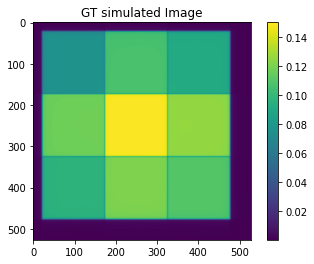

In [53]:
# Create Microscope
# List of all coordinates in the MLA
mla_coordinates = [
    (100, 250),
    (250, 250),
    (400, 250),
    (100, 100),
    (250, 100),
    (400, 100),
    (100, 400),
    (250, 400),
    (400, 400),
]


mla_shape = [psf_size, psf_size]
wb_micro = Microscope(
    optic_config=optic_config,
    members_to_learn=["volume_pred"],
    psf_in=psf_in,
    mla_coordinates=mla_coordinates,
    mla_shape=mla_shape,
    pm_image=pm_image,
).to(device)

wb_micro.eval()

# Create observed FLF image
gt_flf_img = wb_micro(gt_volume.detach()).detach()
try:
    plt.title("GT simulated Image")
    plt.imshow(gt_flf_img[0, 0, :, :].detach().cpu().numpy())
    plt.colorbar()
    plt.show()
except Exception as inst:
    print(inst)

torch.Size([1, 33, 527, 527])


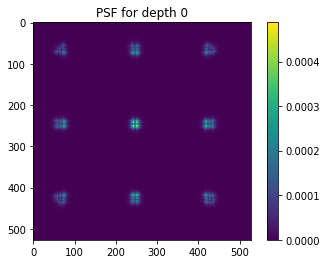

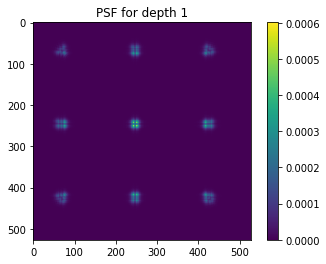

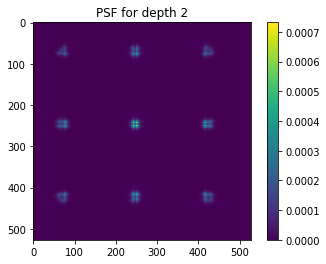

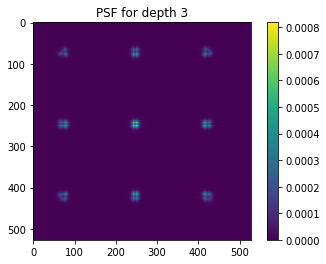

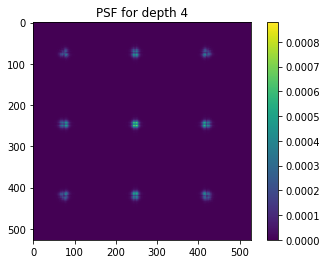

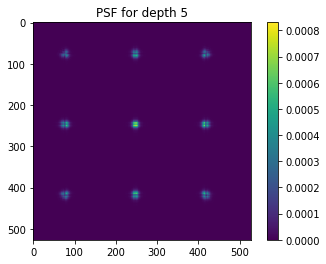

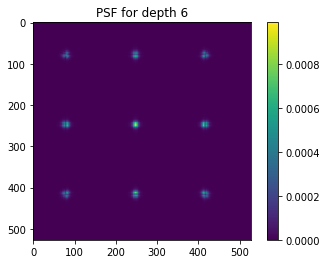

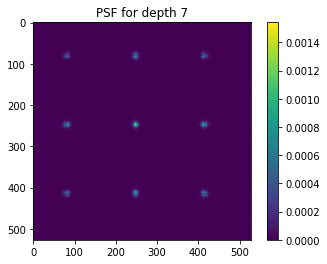

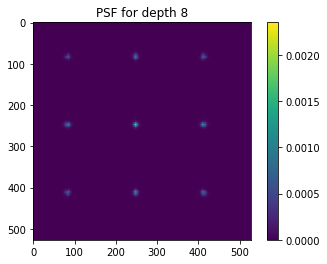

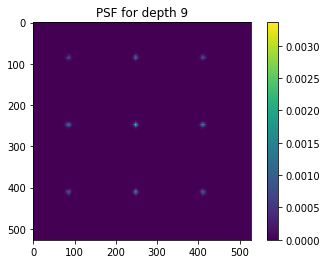

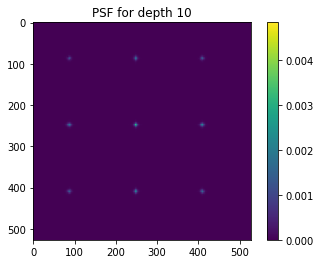

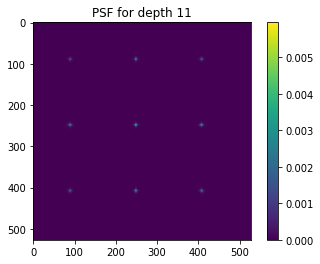

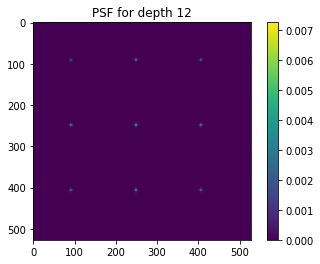

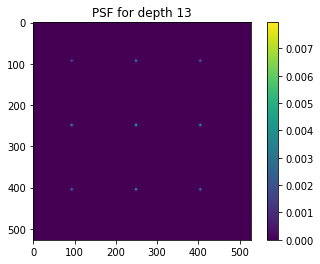

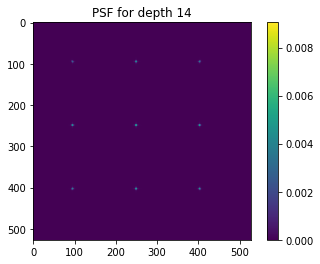

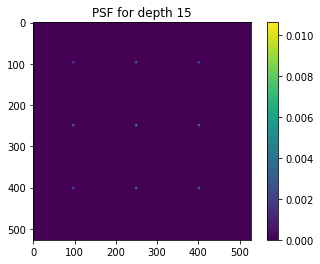

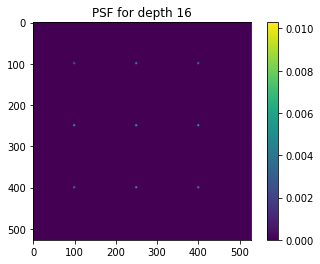

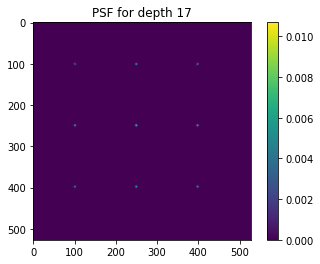

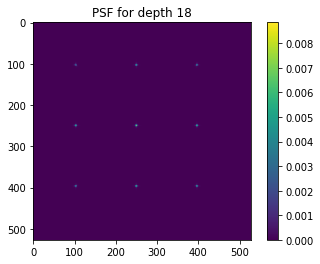

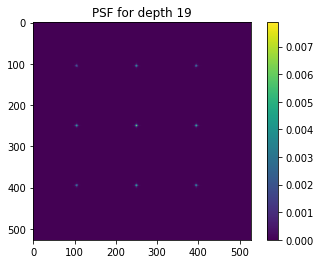

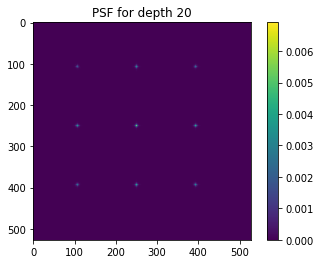

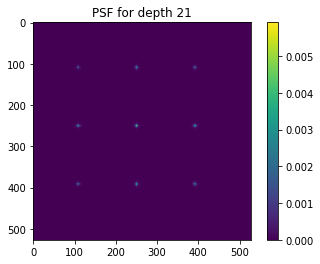

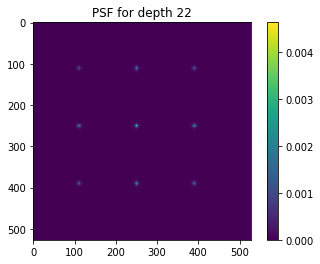

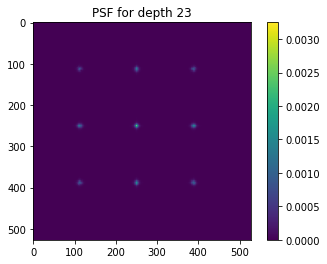

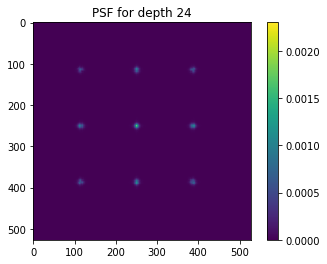

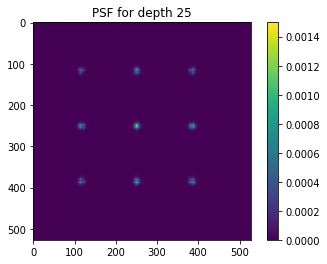

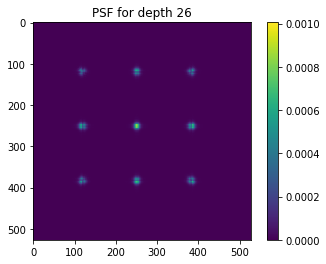

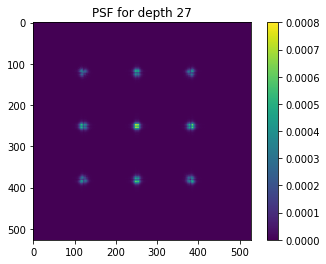

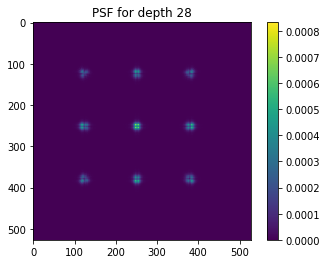

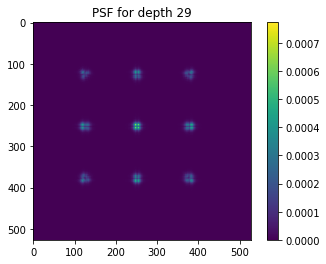

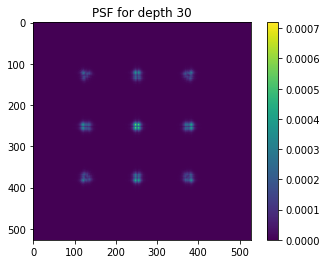

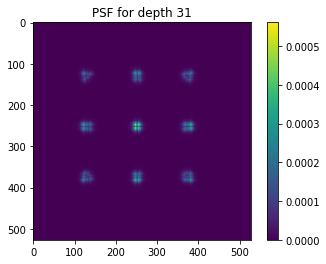

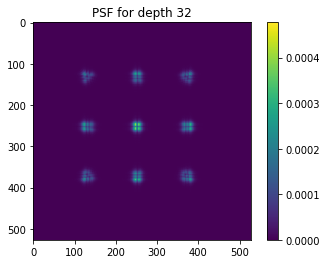

In [55]:
psf_tmp = wb_micro.psf
print(psf_tmp.shape)

for i in range(psf_tmp.shape[1]):
    try:
        plt.imshow(psf_tmp[0,i,:,:].detach().cpu().numpy())# vmin=0,vmax = 0.01
        plt.title("PSF for depth " + str(i))
        plt.colorbar()
        plt.show()
    except Exception as inst:
        print(inst)

